# Omnipose Segmentation from ImageJ Macro converted image directories

This file is meant to aid in omnipose segmentation in a reproducible and streamlined way to help with automated image analysis especially early QC to adjust experimental and imaging parameters as needed to optimize S/N for the experiment. 

#### Import Necessary packages and Functions

In [1]:
# Imports for all chunks
import os
import shutil
from aicsimageio.readers.ome_tiff_reader import OmeTiffReader
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from pathlib import Path
import time


c:\Users\mattt\anaconda3\envs\omni_only\lib\site-packages\pydantic\_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [2]:
# omnipose setup and GPU
from cellpose_omni import models, core
import torch
use_GPU = core.use_gpu()
print('>>> GPU activated? {}'.format(use_GPU))

c:\Users\mattt\anaconda3\envs\omni_only\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-12-12 21:56:15,325 [INFO] ** TORCH GPU version installed and working. **
>>> GPU activated? True


In [3]:


import os
import shutil
from aicsimageio.readers.ome_tiff_reader import OmeTiffReader

# Mapping dictionary for renaming channels
channel_map = {'Phase': 'phase', 'eGFP': 'fish', 'DAPI': 'dapi'}

# Root directory
root_dir = r'C:\Users\mattt\Documents\Omni\Model_evaluations\new_model'  #this would be a directory where your biorep level folder is stored

# Navigate through directories to find OME.TIFF files and rename them
for biorep_dir in os.listdir(root_dir):
    biorep_path = os.path.join(root_dir, biorep_dir)
    if os.path.isdir(biorep_path):
        for date_strain_dir in os.listdir(biorep_path):
            date_strain_path = os.path.join(biorep_path, date_strain_dir)
            if os.path.isdir(date_strain_path):
                for sub_dir in os.listdir(date_strain_path):
                    sub_dir_path = os.path.join(date_strain_path, sub_dir)
                    if os.path.isdir(sub_dir_path):
                        for img_data_dir in os.listdir(sub_dir_path):
                            img_data_path = os.path.join(sub_dir_path, img_data_dir)
                            if os.path.isdir(img_data_path):
                                for file in os.listdir(img_data_path):
                                    if file.endswith('.ome.tiff') or file.endswith('.ome.tif'):
                                        file_path = os.path.join(img_data_path, file)
                                        
                                        # Read the OME.TIFF file to get channel names
                                        reader = OmeTiffReader(file_path)
                                        ome_metadata = reader.ome_metadata
                                        channel_names = [channel.name for channel in ome_metadata.images[0].pixels.channels]
                                        
                                        # Rename folders and files based on channel names
                                        for i, channel_name in enumerate(channel_names):
                                            # Map the original channel name to the new name using the channel_map dictionary
                                            mapped_name = channel_map.get(channel_name, channel_name)
                                            
                                            # Create the old and new folder names based on channel index
                                            old_folder_name = f"C{i+1}-MAX_sequence"
                                            new_folder_name = f"{mapped_name}-MAX_sequence"
                                            
                                            # Create the full path to the old and new folder names
                                            old_folder_path = os.path.join(img_data_path, old_folder_name)
                                            new_folder_path = os.path.join(img_data_path, new_folder_name)
                                            
                                            # If the old folder exists, rename it to the new folder name
                                            if os.path.exists(old_folder_path):
                                                shutil.move(old_folder_path, new_folder_path)
                                            
                                            # Rename individual single-page TIFF files inside the new folder
                                            for single_tiff in os.listdir(new_folder_path):
                                                # Check if the file starts with the old channel name
                                                if single_tiff.startswith(f"C{i+1}-MAX"):
                                                    # Create the full path to the old single-page TIFF file
                                                    old_single_tiff_path = os.path.join(new_folder_path, single_tiff)
                                                    
                                                    # Create the new single-page TIFF file name based on mapped channel name
                                                    new_single_tiff_name = single_tiff.replace(f"C{i+1}-MAX", f"{mapped_name}-MAX")
                                                    
                                                    # Create the full path to the new single-page TIFF file
                                                    new_single_tiff_path = os.path.join(new_folder_path, new_single_tiff_name)
                                                    
                                                    # Rename the old single-page TIFF file to the new name
                                                    shutil.move(old_single_tiff_path, new_single_tiff_path)
                                            
                                            # Create old and new multi-page TIFF file names based on channel index
                                            old_file_name = f"C{i+1}-MAX.tif"
                                            new_file_name = f"{mapped_name}-MAX.tif"
                                            
                                            # Create the full path to the old and new multi-page TIFF files
                                            old_file_path = os.path.join(img_data_path, old_file_name)
                                            new_file_path = os.path.join(img_data_path, new_file_name)
                                            
                                            # If the old multi-page TIFF file exists, rename it to the new name
                                            if os.path.exists(old_file_path):
                                                shutil.move(old_file_path, new_file_path)




## Running Omnipose for Segmentation

Here is the incorporation into the omnipose script

### Importing the images and QC to check images match expectations

### Collecting all the tiff files for omnipose


In [4]:
from skimage import io  # Importing the io module from skimage for image reading

# Initialize an empty list to store the full paths of all phase-MAX_sequence TIFF files.
# This list will include both newly renamed and previously renamed phase files.
all_phase_max_sequence_files = []

# Counter for total images
total_images = 0

# Counter for images with issues
issues_counter = 0

# Use os.walk to navigate through the directory tree rooted at root_dir.
# os.walk yields a 3-tuple (dirpath, dirnames, filenames) for each directory it visits.
# dirpath is the path to the current directory, dirnames is a list of subdirectories in the current directory,
# and filenames is a list of filenames in the current directory.

# Loop through the directory structure
for root, dirs, files in os.walk(root_dir):
    for dir in dirs:
        if dir == "phase-MAX_sequence":
            phase_folder_path = os.path.join(root, dir)
            for file in os.listdir(phase_folder_path):
                if file.endswith(".tif"):
                    full_file_path = os.path.join(phase_folder_path, file)
                    all_phase_max_sequence_files.append(full_file_path)
                    
                    # Read the image into an array
                    img = io.imread(full_file_path)
                    
                    # Perform quality checks
                    shape = img.shape
                    dtype = img.dtype
                    min_val, max_val = img.min(), img.max()

                    # Increment the total_images counter
                    total_images += 1

                    #quality control checks here
                    if shape != (512, 512) or min_val < 3500 or max_val > 35000:
                        issues_counter += 1
                        print(f"Warning: Image at {full_file_path} has issues.")
                        print(f"  - Original image shape: {shape}")
                        print(f"  - Data type: {dtype}")
                        print(f"  - Data range: min {min_val}, max {max_val}")

print(f"\nTotal number of images processed: {total_images}")
if issues_counter:
    print(f"Number of images with issues: {issues_counter}")
else:
    print("No issues found in images.")



Total number of images processed: 56
No issues found in images.


### Segmentation


In [5]:
from skimage.io import imread, imsave
from skimage import img_as_uint 
import numpy as np
from cellpose_omni import models, utils, io as cellpose_io
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import time
from tifffile import TiffFile, imwrite
from tifffile import TiffFile, imsave
import re

# Check for CUDA-enabled GPU availability
# Uncomment this block when you want to switch to GPU computation

import torch

# Check for GPU availability and set the gpu flag
if torch.cuda.is_available():
    gpu = True
    print("CUDA-enabled GPU found. Switching to GPU mode.")
else:
    gpu = False
    print("No CUDA-enabled GPU found. Running on CPU.")



CUDA-enabled GPU found. Switching to GPU mode.


In [12]:
# Define function to create subdirectories
def create_sub_dirs(sequence_folder):
    sub_dirs = ['masks', 'outlines']
    for sub_dir in sub_dirs:
        sub_dir_path = os.path.join(sequence_folder, sub_dir)
        if not os.path.exists(sub_dir_path):
            os.makedirs(sub_dir_path)

# Define Function for saving multi-page results
def create_output_dirs(output_folder):
    sub_dirs = ['cell_only', 'background_only']
    for sub_dir in sub_dirs:
        sub_dir_path = os.path.join(output_folder, sub_dir)
        if not os.path.exists(sub_dir_path):
            os.makedirs(sub_dir_path)

# Function to extract sequence numbers from filenames
def extract_sequence_number(filename):
    match = re.search(r'-(\d{4})\.tif', filename)
    if match:
        return int(match.group(1))
    else:
        return None


# Function for Extracting the Multipage Tiff within Directory     
def find_multipage_tiff(directory):
    current_dir = directory
    parent_dir = os.path.dirname(current_dir)
    all_files = os.listdir(os.path.dirname(current_dir))
    filtered_files = [f for f in all_files if "LZ222" in f and "ome" not in f]
    return os.path.join(parent_dir, filtered_files[0])

# Initialize model
# Initialize model
model_path = r"C:\Users\mattt\Documents\Omni\final_4000_epoch_cellpose_residual_on_style_on_concatenation_off_omni_nclasses_4_omni_retrain_2023_11_01_01_34_28.551587"
model = models.CellposeModel(pretrained_model=model_path, gpu=gpu, nclasses=3, nchan=2)



# define parameters
params = {
    'channels': [0,0],  # Segment based on first channel, no second channel
    'rescale': None,  # upscale or downscale your images, None = no rescaling
    'mask_threshold': -1,  # erode or dilate masks with higher or lower values
    'flow_threshold': 0,  # default is .4, but only needed if there are spurious masks to clean up; slows down output
    'transparency': True,  # transparency in flow output
    'omni': True,  # we can turn off Omnipose mask reconstruction, not advised
    'cluster': True,  # use DBSCAN clustering
    'resample': True,  # whether or not to run dynamics on rescaled grid or original grid
    'verbose': False,  # turn on if you want to see more output
    'tile': False,  # average the outputs from flipped (augmented) images; slower, usually not needed
    'niter': None,  # None lets Omnipose calculate # of Euler iterations (usually <20) but you can tune it for over/under segmentation
    'augment': False,  # Can optionally rotate the image and average outputs, usually not needed
    'affinity_seg': False  # new feature, stay tuned...
}




2023-12-12 23:03:17,591 [INFO] ** TORCH GPU version installed and working. **
2023-12-12 23:03:17,595 [INFO] >>>> using GPU


In [13]:
# Record the start time
start_time = time.time()

## Segmentation and post-processing
for file in sorted(all_phase_max_sequence_files):  # Note the sorting, should be grabbing a file based on its name and reading that image file
    sequence_number = extract_sequence_number(os.path.basename(file))


    # Read the image
    image = imread(file)
    
    # Apply the model
    masks, flows, styles = model.eval(image, **params)
    
    # Generate cell-only and background-only images
    cell_only_image = image * (masks > 0)
    background_only_image = image * (masks == 0)
    
    label_image = label(masks)

    # Create subdirectories for saving within phase-max
    directory = os.path.dirname(file)
    create_sub_dirs(directory)
    filename = os.path.basename(file)
    base_name = os.path.splitext(filename)[0]

     # Find the corresponding multi-page TIFF
    tiff_path = find_multipage_tiff(os.path.dirname(file)) # * i dont know why this is grabbed here seems out of place 
    with TiffFile(tiff_path) as tif: 
        multi_page_tiff = tif.asarray() #read image into a numpy array

    # Initialize output folders
    output_folder_cell_only = os.path.join(os.path.dirname(tiff_path), 'cell_only')
    output_folder_bg_only = os.path.join(os.path.dirname(tiff_path), 'background_only')

    # Create output directories if they don't exist
    create_output_dirs(output_folder_cell_only)
    create_output_dirs(output_folder_bg_only)
    
    sequence_number = sequence_number -1

# Apply the mask to each channel in each timepoint and Z-plane, just use the current mask 
    if sequence_number < multi_page_tiff.shape[0]: 
    
        for z in range(multi_page_tiff.shape[1]):
            for channel in range(multi_page_tiff.shape[2]):
                single_image = multi_page_tiff[sequence_number, z, channel, :, :]
                single_image_cells = single_image * (masks > 0)
                single_image_background = single_image * (masks == 0)
                        
                # Generate the output paths
                output_cell_only_path = os.path.join(output_folder_cell_only, f"Time_{sequence_number}_Z_{z}_Channel_{channel}.tif")
                output_bg_only_path = os.path.join(output_folder_bg_only, f"Time_{sequence_number}_Z_{z}_Channel_{channel}.tif")
                        
                # Save the cell-only and background-only images
                imsave(output_cell_only_path, single_image_cells)
                imsave(output_bg_only_path, single_image_background)
    else:
            print(f"Skipping timepoint {adjusted_timepoint} as it is out of bounds.")

    # Modify the output paths
    output_cell_only_path = os.path.join(directory, 'cell_only', f"{base_name}_cell_only.tif")
    output_background_only_path = os.path.join(directory, 'background_only', f"{base_name}_background_only.tif")
    output_outlines_path = os.path.join(directory, 'outlines', f"{base_name}_outlines.txt")
    output_mask_path = os.path.join(directory, 'masks', f"{base_name}_mask.tif")
    
    # Save the images and outlines
    outlines = utils.outlines_list(masks)
    cellpose_io.outlines_to_text(output_outlines_path, outlines)
    imsave(output_mask_path, masks.astype(np.uint16))

# Record the end time
end_time = time.time()

    # Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time for the code chunk: {elapsed_time:.2f} seconds")

C:\Users\mattt\AppData\Local\Temp\ipykernel_15408\3572663658.py:56: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(output_cell_only_path, single_image_cells)
C:\Users\mattt\AppData\Local\Temp\ipykernel_15408\3572663658.py:57: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(output_bg_only_path, single_image_background)
C:\Users\mattt\AppData\Local\Temp\ipykernel_15408\3572663658.py:70: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(output_mask_path, masks.astype(np.uint16))
C:\Users\mattt\AppData\Local\Temp\ipykernel_15408\3572663658.py:56: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(output_cell_only_path, single_image_cells)
C:\Users\mattt\AppData\Local\Temp\ipykernel_15408\3572663658.py:57: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(output_bg_only_path, single_image_background)
C:\Users\mattt\AppData\L

Elapsed time for the code chunk: 25.91 seconds


C:\Users\mattt\AppData\Local\Temp\ipykernel_15408\3572663658.py:56: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(output_cell_only_path, single_image_cells)
C:\Users\mattt\AppData\Local\Temp\ipykernel_15408\3572663658.py:57: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(output_bg_only_path, single_image_background)
C:\Users\mattt\AppData\Local\Temp\ipykernel_15408\3572663658.py:70: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(output_mask_path, masks.astype(np.uint16))


In [8]:
import pandas as pd
import numpy as np
import scipy.stats
import ast 
import re


# Function to calculate image statistics
def calculate_image_stats(image_path):
    # Read the image
    image = imread(image_path)

    # Check if the image is empty or all zeros
    if image.size == 0 or np.all(image == 0):
        print(f"Warning: The image at {image_path} is empty or all zeros.")
        return None  # Return None to indicate that stats could not be calculated
    
    
    # Filter out the zero pixels
    image = image[image > 0]
    # Initialize a dictionary to store the statistics
    stats_dict = {}
    # Calculate statistics
    stats_dict['mean'] = np.mean(image)
    stats_dict['median'] = np.median(image)
    stats_dict['max'] = np.max(image)
    stats_dict['min'] = np.min(image)
    stats_dict['std_dev'] = np.std(image)
    stats_dict['skewness'] = scipy.stats.skew(image)
    stats_dict['kurtosis'] = scipy.stats.kurtosis(image)
    stats_dict['pixel_count'] = len(image)
    stats_dict['area_covered'] = (len(image)/262144)
    # Extract easy Metadata

    # Extract metadata from the file path
    p = Path(image_path)

    ### From the deepest file level
    try:
        split_stem = p.stem.split('_')
        frame = split_stem[1]
        z_stack = split_stem[3]
        channel = split_stem[5]
        stats_dict['frame'] = frame
        stats_dict['z_stack'] = z_stack
        stats_dict['channel'] = channel
        stats_dict['full_filepath'] = str(p)  # Adding full file path
    except IndexError:
        print(f"Failed to extract frame, z_stack, channel from {p.stem}")

    ### From the directory structure
    root_parts = root.split('\\')
    try:
        condition = root_parts[9].split('_')[-1].split('.')[0]  # 'inf' or 'uninf'
        strain = root_parts[9].split('_')[1]  # 10min, 20min, etc.
        time = root_parts[9].split('_')[2].split('.')[0]  # LZ222##
        stats_dict['condition'] = condition
        stats_dict['time'] = time
        stats_dict['strain'] = strain
    except IndexError:
        print(f"Failed to extract condition, time, strain from {root}")

    # Extract 'image_type' from the directory name
    directory_name = os.path.dirname(image_path)  # Get the directory
    image_type = os.path.basename(directory_name)  # Extract the last part of the directory
    
    # Convert 'background_only' or 'cell_only' to 'background' or 'cell'
    if 'background_only' in image_type:
        image_type = 'background'
    elif 'cell_only' in image_type:
        image_type = 'cell'
    else:
        image_type = 'unknown'
    
    stats_dict['image_type'] = image_type

    biorep = '1'  # All 1 in this case
    stats_dict['biorep'] = biorep

    return stats_dict


# Function to extract metadata for channel naming
def extract_metadata_channel(root_dir):
    metadata_list = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.ome.tiff') or file.endswith('.ome.tif'):
                full_path = os.path.join(root, file)
                reader = OmeTiffReader(full_path)
                ome_metadata = reader.ome_metadata
                channel_names = [channel.name for channel in ome_metadata.images[0].pixels.channels]
                metadata_list.append({'full_filepath': full_path, 'channel_names': channel_names})
    return pd.DataFrame(metadata_list)

#import re  # Importing the regular expression library

def merge_metadata(df, df_metadata, channel_map=None):
    
    """
    Merge metadata into the main dataframe based on matching 'full_filepath'.
    A new column 'signal' is created based on the corresponding 'channel_names' from df_metadata.
    Optionally, a channel_map can be provided to rename the channels.
    
    Parameters:
    df (DataFrame): The main dataframe containing various columns including 'full_filepath' and 'channel'.
    df_metadata (DataFrame): Metadata dataframe containing 'full_filepath' and 'channel_names'.
    channel_map (dict, optional): A dictionary to map original channel names to new names.
    
    """
    # Initialize an empty list to hold the new 'signal' column values
    signal_list = [None] * len(df)
    
    # Loop through each row in df
    for i, row in df.iterrows():
        matched = False  # Variable to indicate if a match was found
        # Loop through each row in df_metadata
        for j, row_metadata in df_metadata.iterrows():
            # Separate the root from the filename using rsplit
            root_metadata = row_metadata['full_filepath'].rsplit('\\', 1)[0]
            
            # Create a regex pattern for the root
            pattern = re.compile(re.escape(root_metadata))
            
            # Use regex to find if the root exists in 'full_filepath' of df
            if pattern.search(row['full_filepath']):
                matched = True  # A match was found, set the variable to True
                # Check if the 'channel' value can be converted to an integer
                try:
                    channel_index = int(row['channel'])
                except ValueError:
                    print(f"Warning: Could not convert channel value {row['channel']} to integer at row {i}.")
                    continue  # Skip this row and continue with the next one

                # Check the type of channel_names and convert if necessary
                if isinstance(row_metadata['channel_names'], str):
                    try:
                        channel_names = ast.literal_eval(row_metadata['channel_names'])
                    except ValueError as e:
                        print(f"Failed to parse channel_names at row {j} in df_metadata: {e}")
                        continue
                else:
                    channel_names = row_metadata['channel_names']


                    # Check if channel_index is within the range of channel_names
                    if 0 <= channel_index < len(channel_names):
                        signal_name = channel_names[channel_index]
                        
                        # Apply channel_map if provided
                        if channel_map and signal_name in channel_map:
                            signal_name = channel_map[signal_name]
                        
                        signal_list[i] = signal_name
                    else:
                        print(f"Warning: channel_index {channel_index} is out of range for channel_names {channel_names} at row {i}.")
                    break  # No need to continue checking for this row, move on to the next one
                if not matched:
                    print(f"Warning: No metadata match found for row {i} with filepath {row['full_filepath']}.")
        # Add the new 'signal' column to df
        df['signal'] = signal_list




#### Statistics and Metadata Assignment Calculation and loop

In [9]:
# Function definitions for tee_stdout and tee_stderr
import sys
from contextlib import contextmanager

@contextmanager
def tee_stdout(file_object):
    old_stdout = sys.stdout
    sys.stdout = Tee(sys.stdout, file_object)
    try:
        yield
    finally:
        sys.stdout = old_stdout

@contextmanager
def tee_stderr(file_object):
    old_stderr = sys.stderr
    sys.stderr = Tee(sys.stderr, file_object)
    try:
        yield
    finally:
        sys.stderr = old_stderr

class Tee:
    def __init__(self, *files):
        self.files = files

    def write(self, obj):
        for f in self.files:
            f.write(obj)

    def flush(self):
        for f in self.files:
            f.flush()

# Create the full path by joining root_dir and filename
filename = 'warnings_and_output.txt'
full_path = os.path.join(root_dir, filename)

# File to save warnings
with open(full_path, 'w') as f:
    with tee_stdout(f), tee_stderr(f):
        # Initialize an empty DataFrame to store the image statistics and metadata
        df = pd.DataFrame()

        # Iterate through directories and sub-directories
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith(".tif") and ('cell_only' in root or 'background_only' in root):
                    file_path = os.path.join(root, file)
                    stats = calculate_image_stats(file_path)
                    
                    if stats is not None:  # Only add to DataFrame if stats were successfully calculated
                        df = pd.concat([df, pd.DataFrame([stats])], ignore_index=True)


In [10]:

# Initialize an empty list to store the extracted information
data_list = []

# Read the text file
with open(full_path) as file:
    lines = file.readlines()
    for line in lines:
        # Use regular expressions to match the pattern and extract the relevant parts
        match = re.search(r'at (.+\\([^\\]+)\\([^\\]+)\\([^\\]+\.tif))', line)
        if match:
            full_path, image_name, image_type, image = match.groups()
            channel = re.search(r'Channel_(\d+)', image).group(1) if re.search(r'Channel_(\d+)', image) else 'Unknown'
            data_list.append([image_name, image_type, image, f"Channel_{channel}"])

# Convert the list to a DataFrame
df_txt = pd.DataFrame(data_list, columns=['image_name', 'image_type', 'image', 'channel'])

# Count the occurrences of each unique row based on the group ['image_name', 'image_type', 'channel']
df_txt['count'] = df_txt.groupby(['image_name', 'image_type', 'channel'])['image_name'].transform('count')

# Drop duplicate rows
df_txt_unique = df_txt.drop_duplicates(subset=['image_name', 'image_type', 'channel'])

df_txt_unique.head()


,image_name,image_type,image,channel,count


In [11]:

# Extract metadata for channel naming
df_metadata = extract_metadata_channel(root_dir)

# Merge the metadata into the DataFrame
merge_metadata(df, df_metadata, channel_map = channel_map)

# Show the DataFrame (For demonstration, will only display the head)
print(df.head())


Empty DataFrame
Columns: []
Index: []


In [12]:

# Specify the filename
filename = 'df.csv'

# Create the full path by joining root_dir and filename
full_path = os.path.join(root_dir, filename)

# Write the DataFrame to a CSV file
df.to_csv(full_path, index=False)


## Analyzing the Background Vs Cell Data


In [13]:
# Reverting to the original function definition
def violin_strip_plot_two_conditions_hue(df, metric, xcondition1, xcondition2, huecondition):
    # Create a deep copy of the DataFrame
    df_copy = df.copy()
    
    # Create a new column combining 'xcondition1' and 'xcondition2'
    df_copy['xcondition1_xcondition2'] = df_copy[xcondition1].astype(str) + "_" + df_copy[xcondition2].astype(str)
    
    plt.figure(figsize=(15, 6))
    
    # Create the violin plot
    sns.violinplot(x='xcondition1_xcondition2', y=metric, data=df_copy, inner=None, dodge=True, color='gray', alpha=0.5)
    
    # Create the strip plot
    sns.stripplot(x='xcondition1_xcondition2', y=metric, data=df_copy, hue=huecondition, dodge=True, jitter=True, marker='o', alpha=0.5)
    
    plt.title(f'{metric.capitalize()} Intensity Across {xcondition1} and {xcondition2}, Colored by {huecondition}')
    plt.legend(title=huecondition, bbox_to_anchor=(1, 1), loc=2)
    plt.tight_layout()
    plt.show()

c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

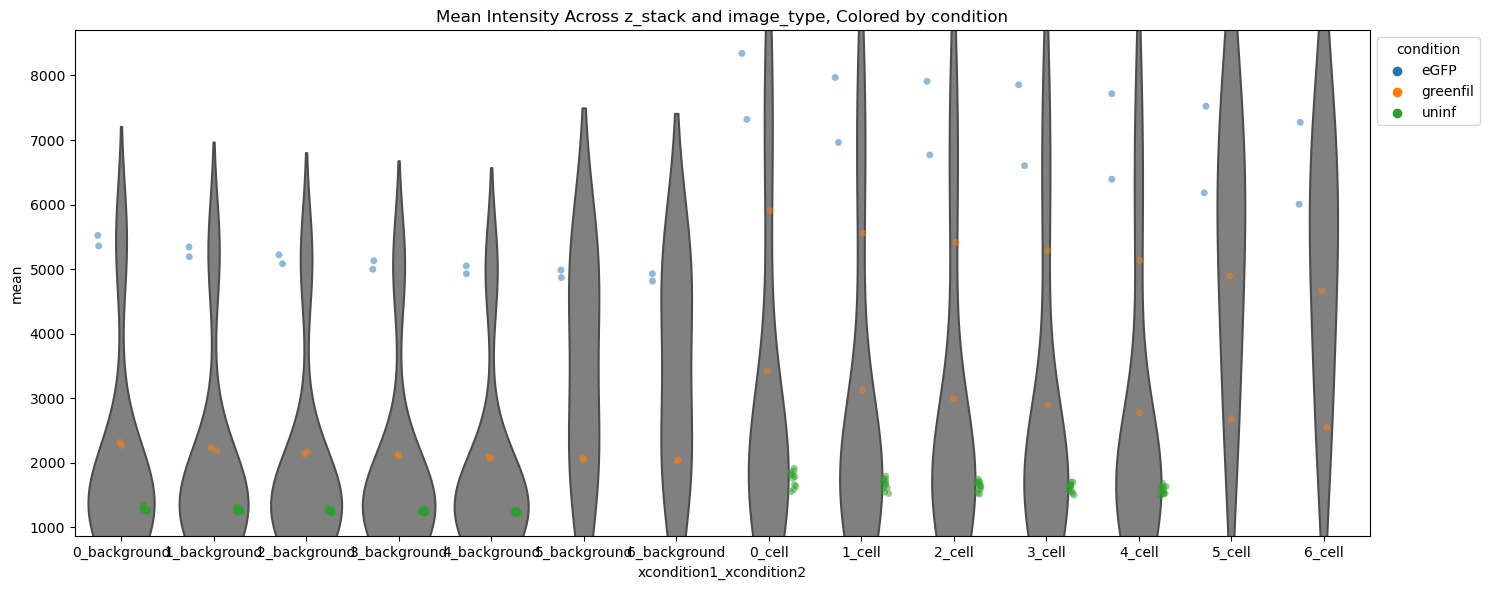

c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

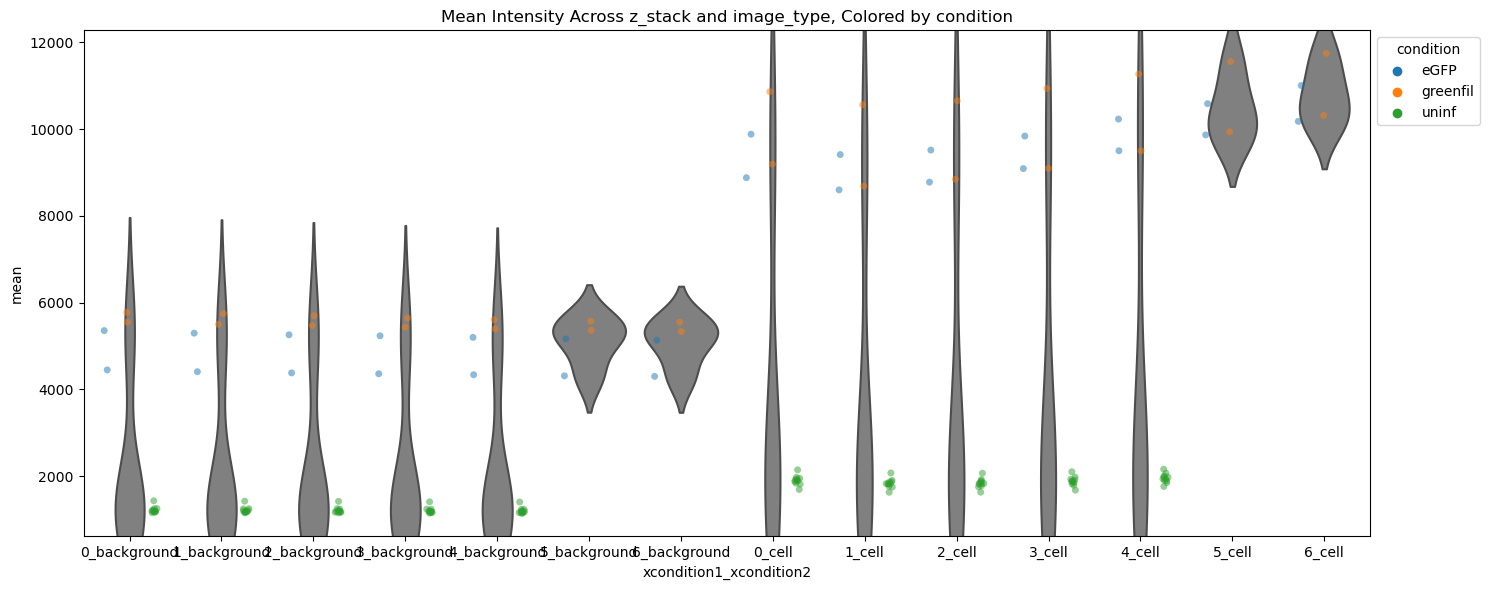

c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

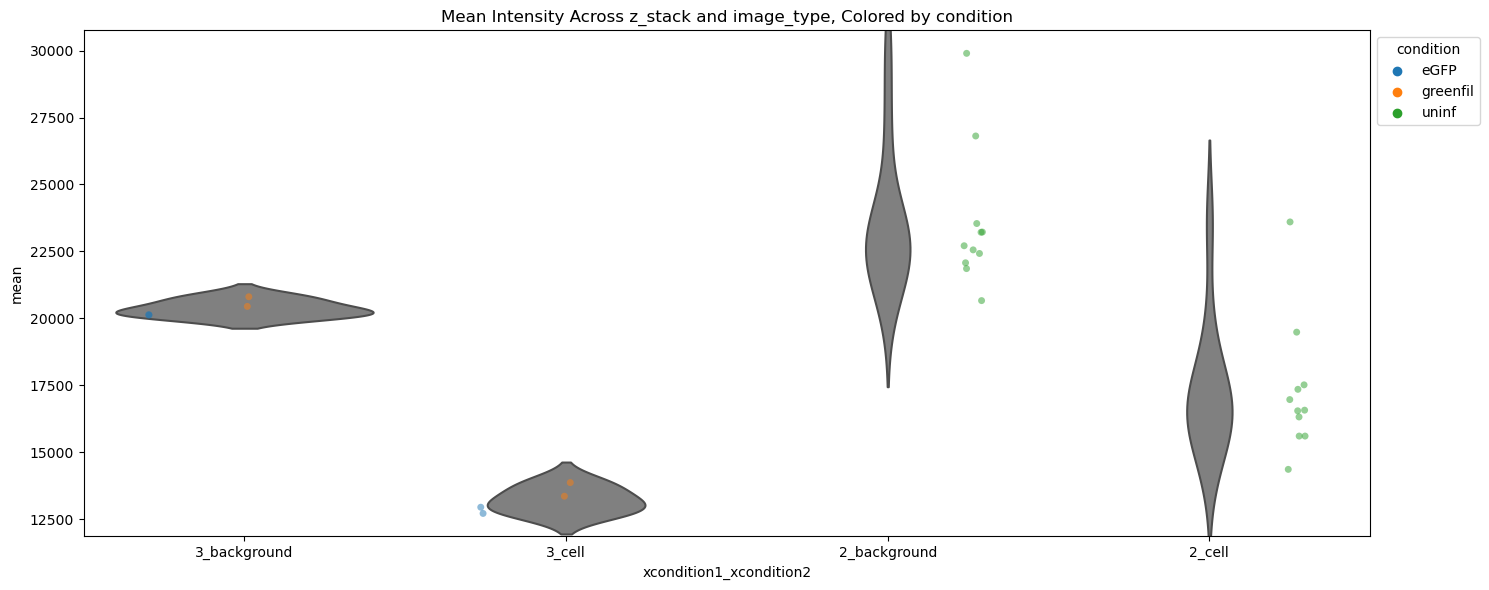

c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

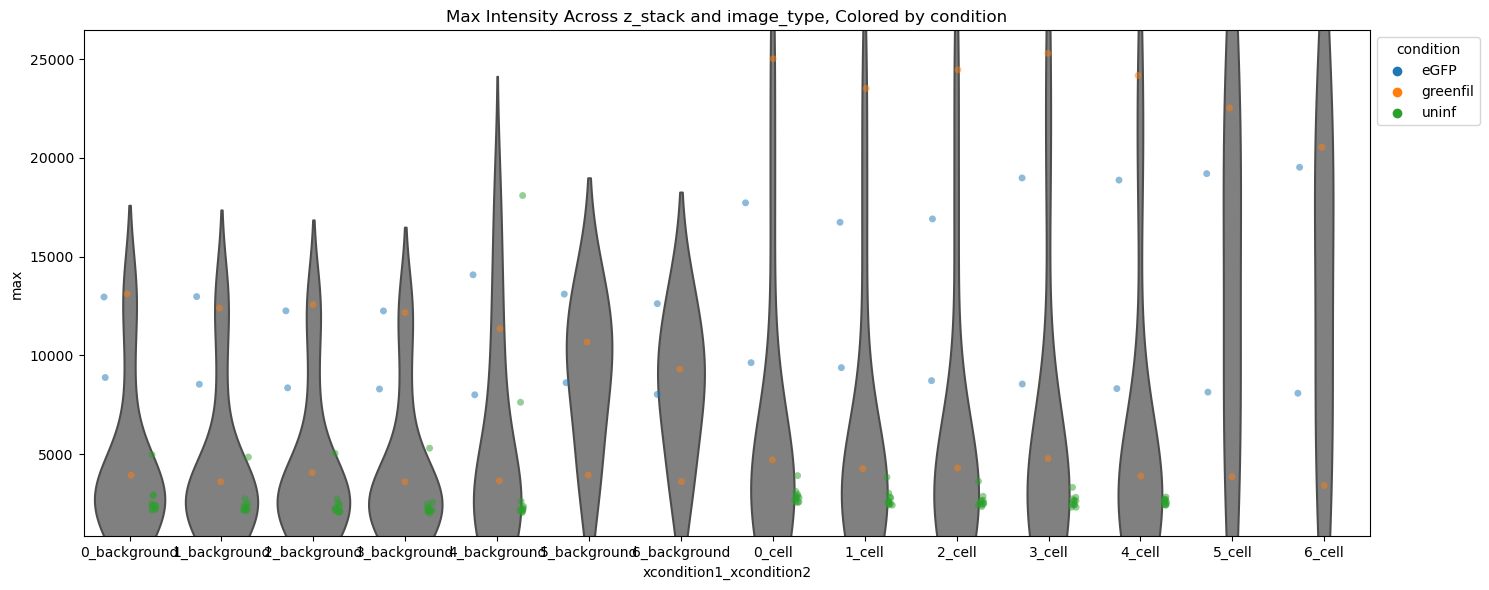

c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

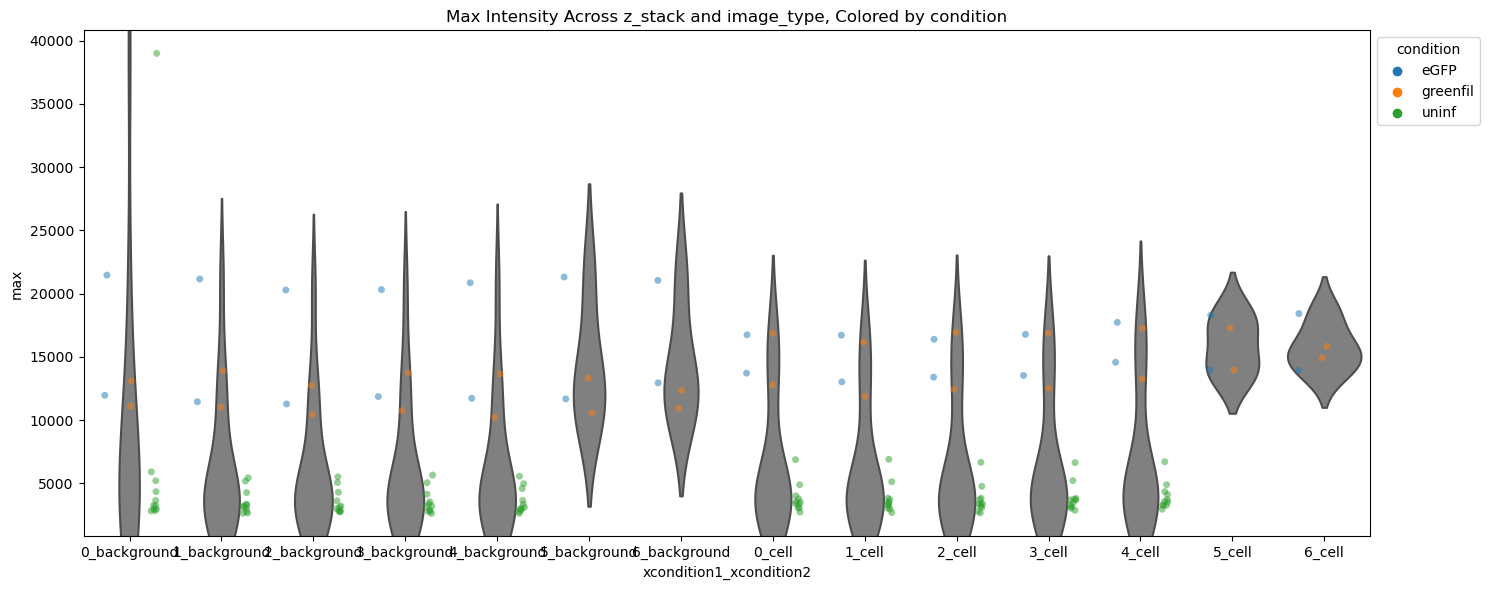

c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

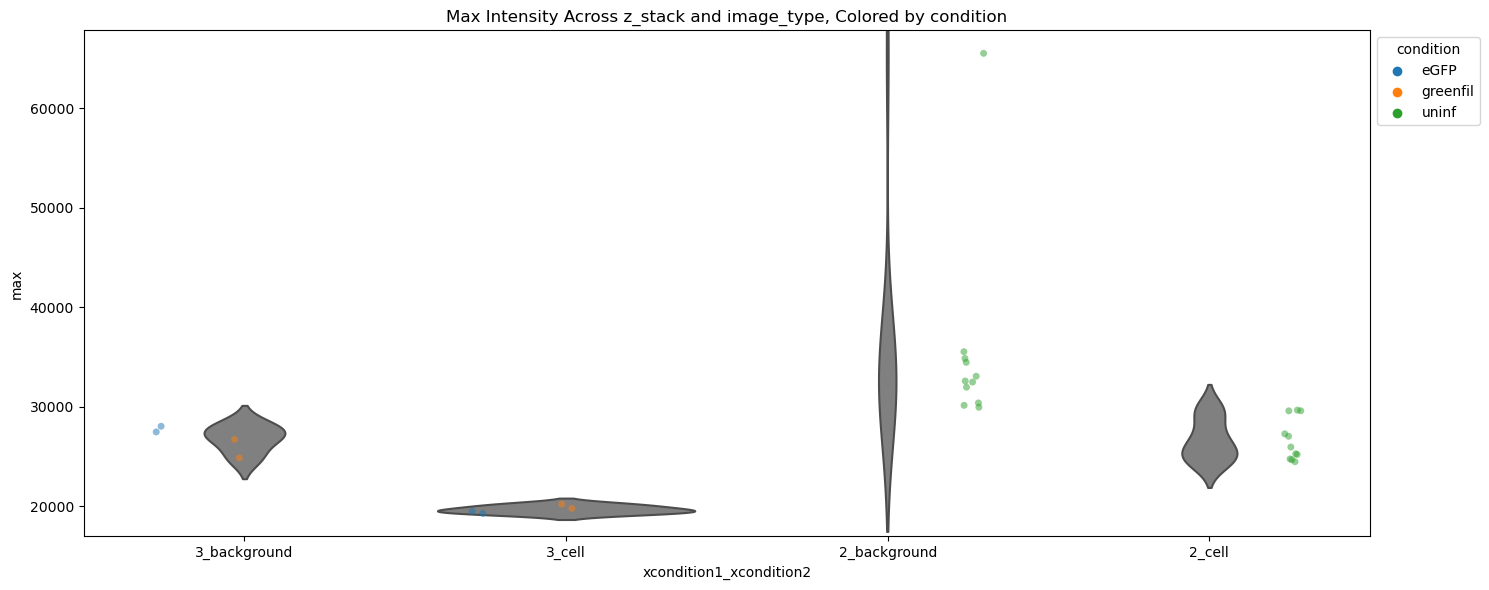

c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

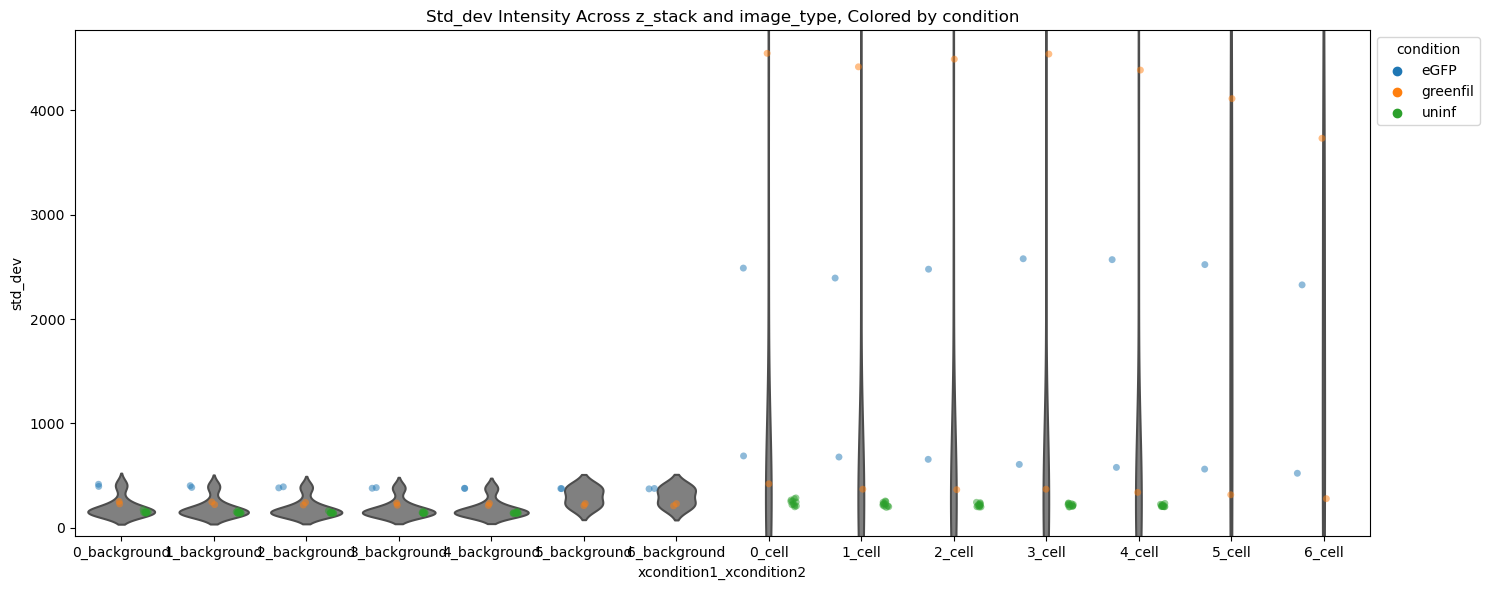

c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

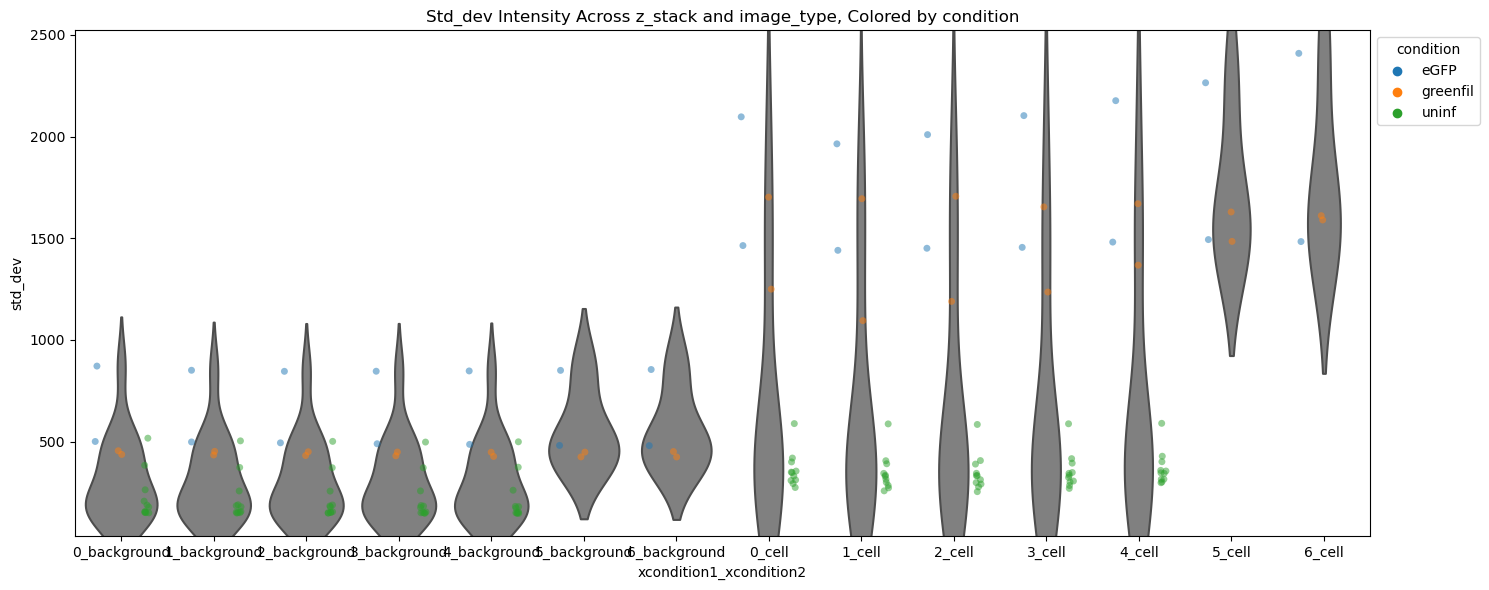

c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

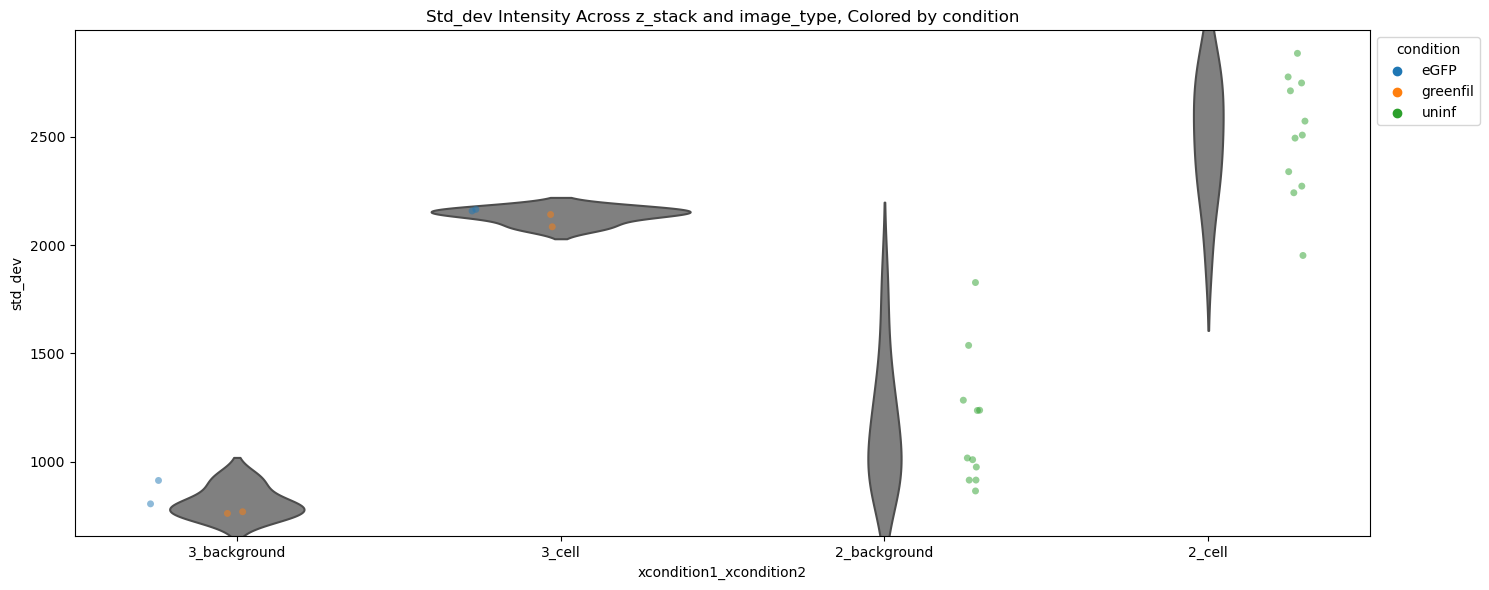

In [54]:
# Setting up the loop to iterate over each metric and signal
metrics = ['mean', 'max', 'std_dev']
signals = df['signal'].unique()
xcondition1 = 'z_stack'
xcondition2 = 'image_type'
huecondition = 'condition'


for metric in metrics:
    for signal in signals:
        # Filter the DataFrame for the current signal
        df_filtered = df[df['signal'] == signal]
        
        # Call the original function with the filtered DataFrame
        violin_strip_plot_two_conditions_hue(df_filtered, metric, xcondition1, xcondition2, 'condition')

In [59]:
## SO now lets calculate some signal to noise stats


def calculate_signal_background(df, metrics, xcondition1, xcondition2, huecondition):
    # Initialize an empty DataFrame to store the results
    signal_background_df = pd.DataFrame()
    
    # Group by the conditions
    grouped = df.groupby([xcondition1, xcondition2, huecondition])
    
    # Loop through each group and calculate the "signal-background"
    for (z_stack, image_type, condition), group in grouped:
        if 'cell' in group['image_type'].values and 'background' in group['image_type'].values:
            # Subtract background values from cell values
            cell_values = group[group['image_type'] == 'cell'][metrics].reset_index(drop=True)
            background_values = group[group['image_type'] == 'background'][metrics].reset_index(drop=True)
            
            # Calculate the difference
            diff = cell_values - background_values
            
            # Assign other columns (z_stack, condition, signal)
            diff[xcondition1] = z_stack
            diff[huecondition] = condition
            diff['signal'] = group['signal'].iloc[0]  # Assuming signal is the same for cell and background
            
            # Append to the results DataFrame
            signal_background_df = pd.concat([signal_background_df, diff])

# Now that we have the "signal-background" values, plot them
    for metric in metrics:
        plt.figure(figsize=(15, 6))
        
        # Create the violin plot
        sns.violinplot(x=xcondition1, y=metric, data=signal_background_df, inner=None, dodge=True, color='gray', alpha=0.5)
        
        # Create the strip plot
        sns.stripplot(x=xcondition1, y=metric, data=signal_background_df, hue=huecondition, dodge=True, jitter=True, marker='o', alpha=0.5)
        
        plt.title(f'{metric.capitalize()} Signal-Background Across {xcondition1}, Colored by {huecondition}')
        plt.legend(title=huecondition, bbox_to_anchor=(1, 1), loc=2)
        plt.tight_layout()
        plt.show()

# Setting up the loop to iterate over each metric and signal
metrics = ['mean', 'max', 'std_dev']
signals = df['signal'].unique()
xcondition2 = 'z_stack'
huecondition = 'condition'

# Call the function with the DataFrame and metrics
calculate_signal_background(df, metrics, signals, xcondition2, huecondition)

ValueError: Grouper and axis must be same length